### Let's run PPO on HalfCheetah!

In [1]:
from optimrl.algorithms.ppo import PPOLossFunction, PPOOptimizer
from optimrl.policy import GymPolicy
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import numpy as np
from tqdm import tqdm
import gymnasium as gym
from torch.distributions.normal import Normal

#### Seeds

In [2]:
SEED = 10
EVAL_SEED = 20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#### Env

In [3]:
env = gym.make('HalfCheetah-v4', render_mode="rgb_array")
obs_dims = env.observation_space.shape[-1]
act_dims = env.action_space.shape[-1]
print(f"Obs dims: {obs_dims}, Action dims: {act_dims}")

Obs dims: 17, Action dims: 6


In [4]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOContinuousPolicy(GymPolicy):
    def __init__(
        self,
        obs_dims,
        act_dims
    ):
        super().__init__()
        self.obs_dims = obs_dims
        self.act_dims = act_dims

        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.obs_dims, 128)),
            nn.Tanh(),
            layer_init(nn.Linear(128, 128)),
            nn.Tanh(),
            layer_init(nn.Linear(128, 1)),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(self.obs_dims, 128)),
            nn.Tanh(),
            layer_init(nn.Linear(128, 128)),
            nn.Tanh(),
            layer_init(nn.Linear(128, self.act_dims), std=0.01),
            nn.Tanh(),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(self.act_dims)))

    def forward(self, obs: torch.Tensor, actions = None, policy_out = {}):
        obs = obs.float()
        values = self.critic(obs)
        action_mean = self.actor_mean(obs)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        dist = Normal(action_mean, action_std)
        entropy = dist.entropy().sum(1)
        if actions is None:
            actions = dist.sample()
        actions = actions.float()
        log_probs = dist.log_prob(actions).sum(1)
        return {"actions":actions, "values":values, "log_probs":log_probs, "dist":dist, "entropy":entropy}

    def act(self, obs: torch.Tensor, actions = None, policy_out = {}):
        with torch.no_grad():
            out = self.forward(torch.from_numpy(obs), actions=actions, policy_out = policy_out)
            return out["actions"].detach().cpu().numpy(), out

#### Train

##### Setup optimizer

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
policy = PPOContinuousPolicy(obs_dims, act_dims)
loss_fn = PPOLossFunction(clip_ratio=0.2, ent_coef=0.01, vf_coef=0.5)
optimizer = PPOOptimizer(policy, loss_fn, pi_lr=2e-4, n_updates=5, num_minibatches=32)

policy = policy.to(device)
optimizer = optimizer.to(device)

##### Create vector envs

In [6]:
def make_env(env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    env = gym.wrappers.ClipAction(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    return env

train_envs = gym.vector.SyncVectorEnv(
    [lambda: make_env('HalfCheetah-v4') for i in range(16)],
)
test_envs = gym.vector.SyncVectorEnv(
    [lambda: make_env('HalfCheetah-v4') for i in range(1)],
)

##### Main loop

In [7]:
NUM_STEPS = 20000
MAX_ENV_STEPS = 128

In [8]:
mean_train_rewards = []
mean_test_rewards = []
bar = tqdm(np.arange(NUM_STEPS))

for i in bar:
    with torch.no_grad():
        train_rollout = optimizer.rollout(train_envs, policy, MAX_ENV_STEPS, SEED, evaluate=False)
        eval_rollout = optimizer.rollout(test_envs, policy, MAX_ENV_STEPS, EVAL_SEED, evaluate=True)
    loss, rewards, stats = optimizer.step(
        train_rollout.to_torch(
            device=optimizer.device
        )
    )
    mean_train_rewards.append(train_rollout.stats["sum_rewards"])
    mean_test_rewards.append(eval_rollout.stats["sum_rewards"])
    if i % 50 == 0:
        print(f"Train: {np.mean(mean_train_rewards[-20:])} Test: {np.mean(mean_test_rewards[-20:])}")

  0%|                                                               | 1/20000 [00:00<1:48:55,  3.06it/s]

Train: -28.367511920648084 Test: -73.10209448150113


  0%|▏                                                             | 51/20000 [00:13<1:30:58,  3.65it/s]

Train: -18.103806028859303 Test: -18.934813834785164


  1%|▎                                                            | 101/20000 [00:27<1:28:06,  3.76it/s]

Train: -1.4473341709834062 Test: 12.79148697517233


  1%|▍                                                            | 151/20000 [00:40<1:27:50,  3.77it/s]

Train: 16.80315513076605 Test: 27.790127826085534


  1%|▌                                                            | 201/20000 [00:53<1:27:14,  3.78it/s]

Train: 47.86183686622608 Test: 41.79066834016594


  1%|▊                                                            | 251/20000 [01:07<1:27:16,  3.77it/s]

Train: 83.93967325926755 Test: 87.10104938616185


  2%|▉                                                            | 301/20000 [01:20<1:26:49,  3.78it/s]

Train: 112.8820234202005 Test: 132.1176059698723


  2%|█                                                            | 351/20000 [01:33<1:26:38,  3.78it/s]

Train: 135.64858604311553 Test: 139.19391941798705


  2%|█▏                                                           | 401/20000 [01:46<1:25:28,  3.82it/s]

Train: 152.6603366584236 Test: 160.8469166253679


  2%|█▍                                                           | 451/20000 [01:59<1:25:34,  3.81it/s]

Train: 176.12205280772054 Test: 176.8572777432859


  3%|█▌                                                           | 501/20000 [02:13<1:24:48,  3.83it/s]

Train: 180.69057694094346 Test: 183.46231523732106


  3%|█▋                                                           | 551/20000 [02:26<1:24:49,  3.82it/s]

Train: 202.76097536793742 Test: 194.18472775661286


  3%|█▊                                                           | 601/20000 [02:39<1:24:49,  3.81it/s]

Train: 215.28811700216153 Test: 192.91062196235285


  3%|█▉                                                           | 651/20000 [02:52<1:24:43,  3.81it/s]

Train: 220.33340551403504 Test: 203.1117728192719


  4%|██▏                                                          | 701/20000 [03:05<1:24:02,  3.83it/s]

Train: 226.60407690770012 Test: 228.29089530441644


  4%|██▎                                                          | 751/20000 [03:18<1:23:48,  3.83it/s]

Train: 248.62151534408207 Test: 236.7133680250701


  4%|██▍                                                          | 801/20000 [03:32<1:23:00,  3.86it/s]

Train: 252.3843185602287 Test: 255.19058398224314


  4%|██▌                                                          | 851/20000 [03:45<1:27:39,  3.64it/s]

Train: 265.65090496000295 Test: 280.7010941631085


  5%|██▋                                                          | 901/20000 [03:58<1:26:16,  3.69it/s]

Train: 271.9896269060347 Test: 286.17550537990905


  5%|██▉                                                          | 951/20000 [04:11<1:24:42,  3.75it/s]

Train: 292.3139060553011 Test: 304.34806632939916


  5%|███                                                         | 1001/20000 [04:24<1:31:30,  3.46it/s]

Train: 296.5901371210191 Test: 291.9570830269923


  5%|███▏                                                        | 1051/20000 [04:38<1:22:08,  3.84it/s]

Train: 317.1514506062787 Test: 307.1435752765333


  6%|███▎                                                        | 1101/20000 [04:51<1:21:52,  3.85it/s]

Train: 324.9412039360448 Test: 330.3772734627893


  6%|███▍                                                        | 1151/20000 [05:04<1:22:11,  3.82it/s]

Train: 337.3080562982276 Test: 337.7694755818195


  6%|███▌                                                        | 1201/20000 [05:17<1:21:39,  3.84it/s]

Train: 345.25283757304163 Test: 345.65347201071285


  6%|███▊                                                        | 1251/20000 [05:30<1:21:31,  3.83it/s]

Train: 348.1981680929179 Test: 354.8353848428604


  7%|███▉                                                        | 1301/20000 [05:43<1:28:59,  3.50it/s]

Train: 345.458278279098 Test: 323.3924472367185


  7%|████                                                        | 1351/20000 [05:57<1:21:02,  3.84it/s]

Train: 340.43542858033913 Test: 352.6096446229489


  7%|████▏                                                       | 1401/20000 [06:10<1:20:58,  3.83it/s]

Train: 362.417564691442 Test: 369.80082594412784


  7%|████▎                                                       | 1421/20000 [06:15<1:21:50,  3.78it/s]

KeyboardInterrupt



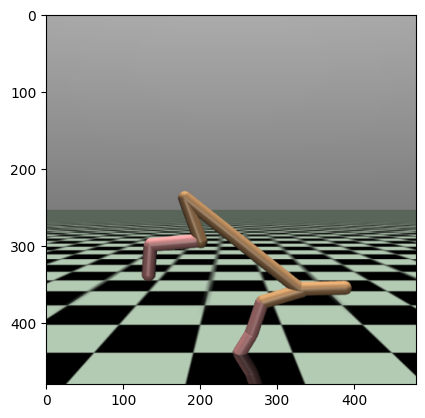

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Sample list of NumPy arrays
with torch.no_grad():
    eval_rollout = optimizer.rollout(test_envs, policy, MAX_ENV_STEPS, EVAL_SEED, evaluate=True, render=True)
    
# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(eval_rollout.renders[0], cmap='viridis')

# Update function for the animation
def update(frame):
    im.set_array(eval_rollout.renders[frame])
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=len(eval_rollout.renders), interval=60, blit=True)

# Display the animation
HTML(ani.to_html5_video())

In [ ]:
renders = [step.renders for step in eval_rollout.steps]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Sample list of NumPy arrays
arrays = [np.random.rand(10, 10, 3) for _ in range(10)]

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(arrays[0], cmap='viridis')

# Update function for the animation
def update(frame):
    im.set_array(arrays[frame])
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=len(arrays), interval=500, blit=True)

# Display the animation
HTML(ani.to_html5_video())